# Particle spray algorithm by Chen et al. (2024)

Author: Yingtian "Bill" Chen

We provide a notebook to generate streams using the Chen+24 ([arXiv:2408.01496](https://arxiv.org/abs/2408.01496)) model via `galax`. This implementation has not yet been merged to the `main` branch of `galax`. Also, `galax` cuurently doesn't support orbit integration with the progenitor's potential, which is essential for our default model. But you can still play with our "no progenitor" model by checking out my fork of `galax`. To do so, you need to

1. (Optional) Create a new virtual environment in case you already have your own `galax` and don't want to mess it up. And make sure you are using `python >= 3.10`
```
$ conda create --name galax_chen24 python=3.12
$ conda activate galax_chen24
```

2. To properly use `galax`, make sure you have installed `gala`. If not, follow the [installation instructuon of `gala`](https://gala.adrian.pw/en/latest/install.html)

2. Clone my fork of `gala` and checkout the corret branch
```
$ git clone https://github.com/ybillchen/galax_chen24.git
$ cd galax_chen24
$ git checkout stream_df_chen24
```

3. Install the package
```
$ python -m pip install .
```

4. (Optional) Don't forget to switch the kernel of this notebook to the virtual environment you have just created! To do so, you need to install `ipykernel`

Then you are done! Let's checkout what you can do now.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import jax.random as jr

from unxt import Quantity
import galax.coordinates as gc
import galax.potential as gp
import galax.dynamics as gd

In [2]:
pot = gp.BovyMWPotential2014()

w = gc.PhaseSpacePosition(q=Quantity([40, 0, 0], "kpc"),
                          p=Quantity([0, 100, 0], "km/s"),
                          t=Quantity(0, "Gyr"))

prog_orbit = pot.evaluate_orbit(w, t=Quantity([0, 1, 2], "Gyr"))
prog_mass = Quantity(1e5, "Msun")

In [3]:
# Fardal+15
df = gd.FardalStreamDF()
gen = gd.MockStreamGenerator(df, pot)
%time stream_f15, _ = gen.run(jr.key(0),Quantity(np.arange(500+1)*6, "Myr"), w, prog_mass)

# Chen+24 (no prog.)
df = gd.ChenStreamDF()
gen = gd.MockStreamGenerator(df, pot)
%time stream_c24, _ = gen.run(jr.key(0),Quantity(np.arange(500+1)*6, "Myr"), w, prog_mass)

CPU times: user 10.4 s, sys: 541 ms, total: 11 s
Wall time: 11 s


/Users/ybchen/Documents/galax_chen24/src/galax/dynamics/_dynamics/mockstream/df/chen24.py:53: RuntimeWarning: Currently only the "no progenitor" version of the Chen+24 model is supported!
  warnings.warn(


CPU times: user 9.31 s, sys: 471 ms, total: 9.79 s
Wall time: 9.79 s


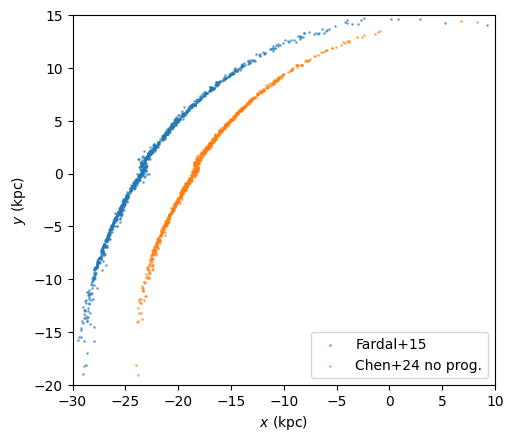

In [4]:
plt.scatter(stream_f15.q.x.value-5, stream_f15.q.y.value, s=1, alpha=0.5, label='Fardal+15')
plt.scatter(stream_c24.q.x.value, stream_c24.q.y.value, s=1, alpha=0.5, label='Chen+24 no prog.')

plt.xlabel(r'$x\ ({\rm kpc})$')
plt.ylabel(r'$y\ ({\rm kpc})$')
plt.xlim(-30, 10)
plt.ylim(-20, 15)
plt.legend()
plt.gca().set_aspect(1)
plt.show()